In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import tarfile
import pandas as pd
import numpy as np
import igraph as ig
import torch
import numpy as np
import dgl
import tqdm
import sklearn.metrics

In [2]:
df = pd.read_csv("pokec-df-processed2.csv", index_col=0)

In [4]:
edges = pd.read_csv("pokec-edges-processed2.csv", index_col=0)

In [5]:
# фичи и возраст
node_features = df.loc[:, df.columns != 'AGE'].values
node_labels = df.loc[:, df.columns == 'AGE'].values.flatten()
node_features = torch.FloatTensor(node_features)
node_labels = torch.LongTensor(node_labels)

In [6]:
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()

In [7]:
graph = dgl.graph((edges.values[:, 0], edges.values[:, 1]))

In [8]:
with open('train2.txt', 'r') as file:
    train_nids = [int(x) for x in file]
with open('test2.txt', 'r') as file:
    test_nids = [int(x) for x in file]

In [9]:
ind = df.index.values

In [10]:
import time

import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import AddSelfLoop

In [12]:
class GAT(nn.Module):
    def __init__(self, in_size, hid_size, out_size, heads):
        super().__init__()
        self.gat_layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=0.5)
        # two-layer GAT
        self.gat_layers.append(
            dglnn.GATConv(
                in_size,
                hid_size,
                heads[0],
                feat_drop=0.6,
                attn_drop=0.6,
                activation=F.elu,
            )
        )
        self.gat_layers.append(
            dglnn.GATConv(
                hid_size * heads[0],
                out_size,
                heads[1],
                feat_drop=0.6,
                attn_drop=0.6,
                activation=None,
            )
        )

    def forward(self, g, inputs):
        h = inputs
        for i, layer in enumerate(self.gat_layers):
            h = layer(g, h)
            if i == len(self.gat_layers) - 1:
                h = h.mean(1)
            else:
                h = h.flatten(1)
            if i == 0:
                h = self.dropout(h)
        return h


def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def predict(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        return indices


def train(g, features, labels, masks, model, num_epochs):
    train_mask = masks[0]
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)
    train_loss = []
    train_mae = []

    for epoch in range(num_epochs):
        t0 = time.time()
        model.train()
        logits = model(g, features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])
        train_loss.append(loss.item())
        train_mae.append(sklearn.metrics.mean_absolute_error(predict(g, features, labels, train_mask, model).numpy(), labels[train_mask].numpy()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t1 = time.time()
        print(
            "Epoch {:05d} | Loss {:.4f} | mae {:.4f} | Time {:.4f}".format(
                epoch, loss.item(), train_mae[-1], t1 - t0
            )
        )
    # plot loss
    plt.plot(train_loss)
    plt.title('GAT loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    # plot accuracy
    plt.plot(train_mae)
    plt.title('GAT mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.show()

Training...
Epoch 00000 | Loss 1256.9908 | mae 50.1960 | Time 31.9696
Epoch 00001 | Loss 1044.5229 | mae 53.2908 | Time 31.6555
Epoch 00002 | Loss 737.4778 | mae 53.0033 | Time 27.0853
Epoch 00003 | Loss 459.6223 | mae 52.3210 | Time 26.2600
Epoch 00004 | Loss 302.2218 | mae 51.8139 | Time 32.0374
Epoch 00005 | Loss 245.7486 | mae 51.5033 | Time 30.5099
Epoch 00006 | Loss 205.2973 | mae 50.8654 | Time 30.2671
Epoch 00007 | Loss 170.8254 | mae 50.7710 | Time 30.3174
Epoch 00008 | Loss 153.3625 | mae 50.7289 | Time 30.5889
Epoch 00009 | Loss 133.0510 | mae 50.6061 | Time 30.3898
Epoch 00010 | Loss 116.9466 | mae 50.3541 | Time 30.4502
Epoch 00011 | Loss 110.2101 | mae 50.2175 | Time 30.4541
Epoch 00012 | Loss 97.1194 | mae 50.0317 | Time 26.5014
Epoch 00013 | Loss 89.2105 | mae 49.8559 | Time 26.5001
Epoch 00014 | Loss 80.2249 | mae 49.6181 | Time 27.7772
Epoch 00015 | Loss 77.6283 | mae 49.3605 | Time 27.5425
Epoch 00016 | Loss 72.9190 | mae 49.0346 | Time 29.7675
Epoch 00017 | Loss 69.

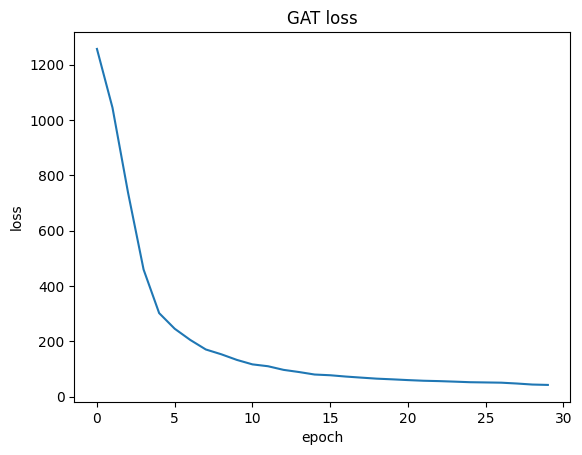

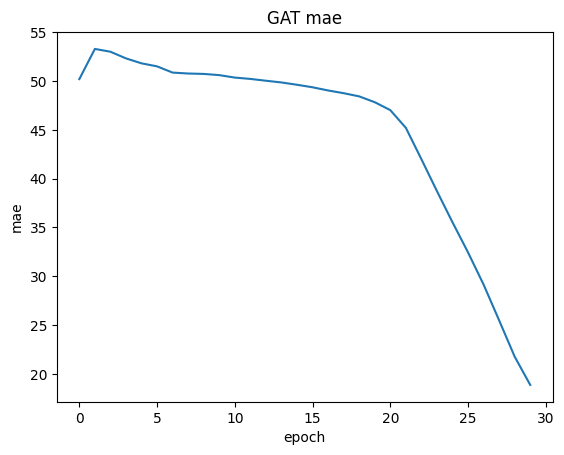

In [22]:
g = graph
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
g = dgl.add_self_loop(g)
g = g.int().to(device)
features = torch.FloatTensor(node_features)
labels = torch.LongTensor(node_labels)
masks = torch.BoolTensor(np.isin(ind, train_nids)), torch.BoolTensor(np.isin(ind, test_nids))

# Create GAT model
in_size = features.shape[1]
out_size = num_classes
num_epochs = 30
model = GAT(in_size, 9, out_size, heads=[9, 1]).to(device)

print("Training...")
train(g, features, labels, masks, model, num_epochs)

In [25]:
best_model_path = 'GAT_model.pt'

Epoch 00030 | Loss 38.3678 | mae 11.3423 | Time 25.7835
Epoch 00031 | Loss 34.8864 | mae 8.4579 | Time 26.7431
Epoch 00032 | Loss 32.4149 | mae 7.3778 | Time 25.9667
Epoch 00033 | Loss 29.4244 | mae 7.1271 | Time 25.8774
Epoch 00034 | Loss 26.7740 | mae 7.1137 | Time 27.4502
Epoch 00035 | Loss 24.0839 | mae 7.1117 | Time 27.8675
Epoch 00036 | Loss 22.0391 | mae 7.1059 | Time 27.8371
Epoch 00037 | Loss 20.8099 | mae 7.1012 | Time 27.4896
Epoch 00038 | Loss 20.1234 | mae 7.0917 | Time 27.6832
Epoch 00039 | Loss 18.5837 | mae 7.0814 | Time 27.0016
Epoch 00040 | Loss 17.5144 | mae 7.0766 | Time 27.2637
Epoch 00041 | Loss 16.4347 | mae 7.0783 | Time 26.1943
Epoch 00042 | Loss 15.7029 | mae 7.0919 | Time 26.6783
Epoch 00043 | Loss 14.9080 | mae 7.1106 | Time 27.2442
Epoch 00044 | Loss 14.1589 | mae 7.1371 | Time 26.5442
Epoch 00045 | Loss 13.5980 | mae 7.1617 | Time 26.0164
Epoch 00046 | Loss 12.9216 | mae 7.1886 | Time 26.6656
Epoch 00047 | Loss 12.4115 | mae 7.2016 | Time 25.9418
Epoch 000

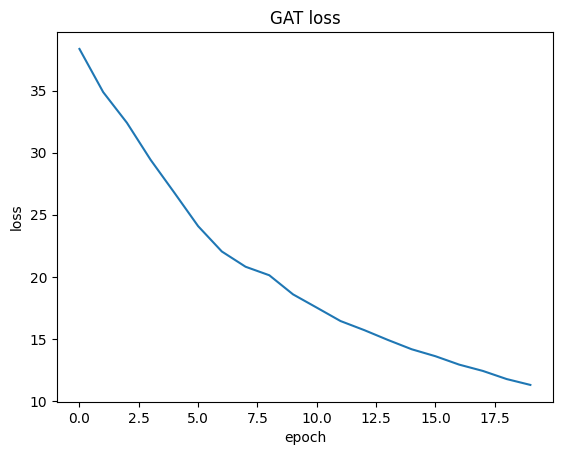

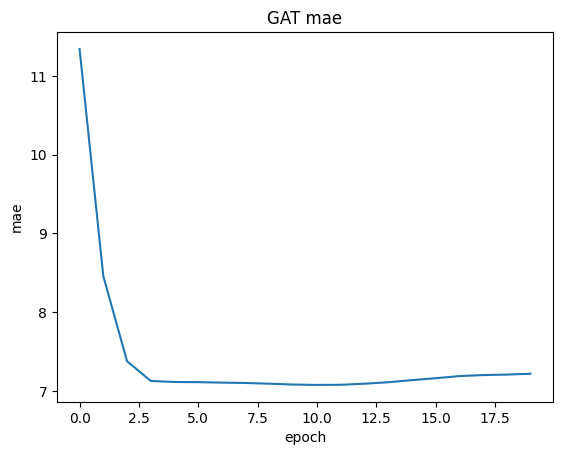

In [26]:
train_mask = masks[0]
loss_fcn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)
train_loss = []
train_mae = []
num_epochs = 20
best_mae = 10**10

for epoch in range(30, 30 + num_epochs):
    t0 = time.time()
    model.train()
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])
    train_loss.append(loss.item())
    train_mae.append(sklearn.metrics.mean_absolute_error(predict(g, features, labels, train_mask, model).numpy(), labels[train_mask].numpy()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    t1 = time.time()
    print(
        "Epoch {:05d} | Loss {:.4f} | mae {:.4f} | Time {:.4f}".format(
                epoch, loss.item(), train_mae[-1], t1 - t0
        )
    )
    if best_mae > train_mae[-1]:
        best_mae = train_mae[-1]
        torch.save(model.state_dict(), best_model_path)
# plot loss
plt.plot(train_loss)
plt.title('GAT loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
# plot accuracy
plt.plot(train_mae)
plt.title('GAT mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [28]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [29]:
test_predictions = predict(g, features, labels, masks[1], model)
test_labels = node_labels[test_nids]
test_mae = sklearn.metrics.mean_absolute_error(test_predictions.numpy(), test_labels.numpy())
print('Test MAE:', test_mae)

Test MAE: 7.0575251601097895
